## Analysis of DENV in Hepatoma cell 

# Import necessary packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gseapy import enrichr
import textwrap

In [27]:
# Count DEGs for DENV and ZIKV
# Make sure denv_up, denv_down, zikv_up, zikv_down are already created in your code using DEG thresholds

den_up_count = len(denv_up)
den_down_count = len(denv_down)
zikv_up_count = len(zikv_up)
zikv_down_count = len(zikv_down)

print("DEG Counts:")
print(f"DENV Upregulated: {den_up_count}")
print(f"DENV Downregulated: {den_down_count}")
print(f"ZIKV Upregulated: {zikv_up_count}")
print(f"ZIKV Downregulated: {zikv_down_count}")


DEG Counts:
DENV Upregulated: 280
DENV Downregulated: 68
ZIKV Upregulated: 472
ZIKV Downregulated: 429


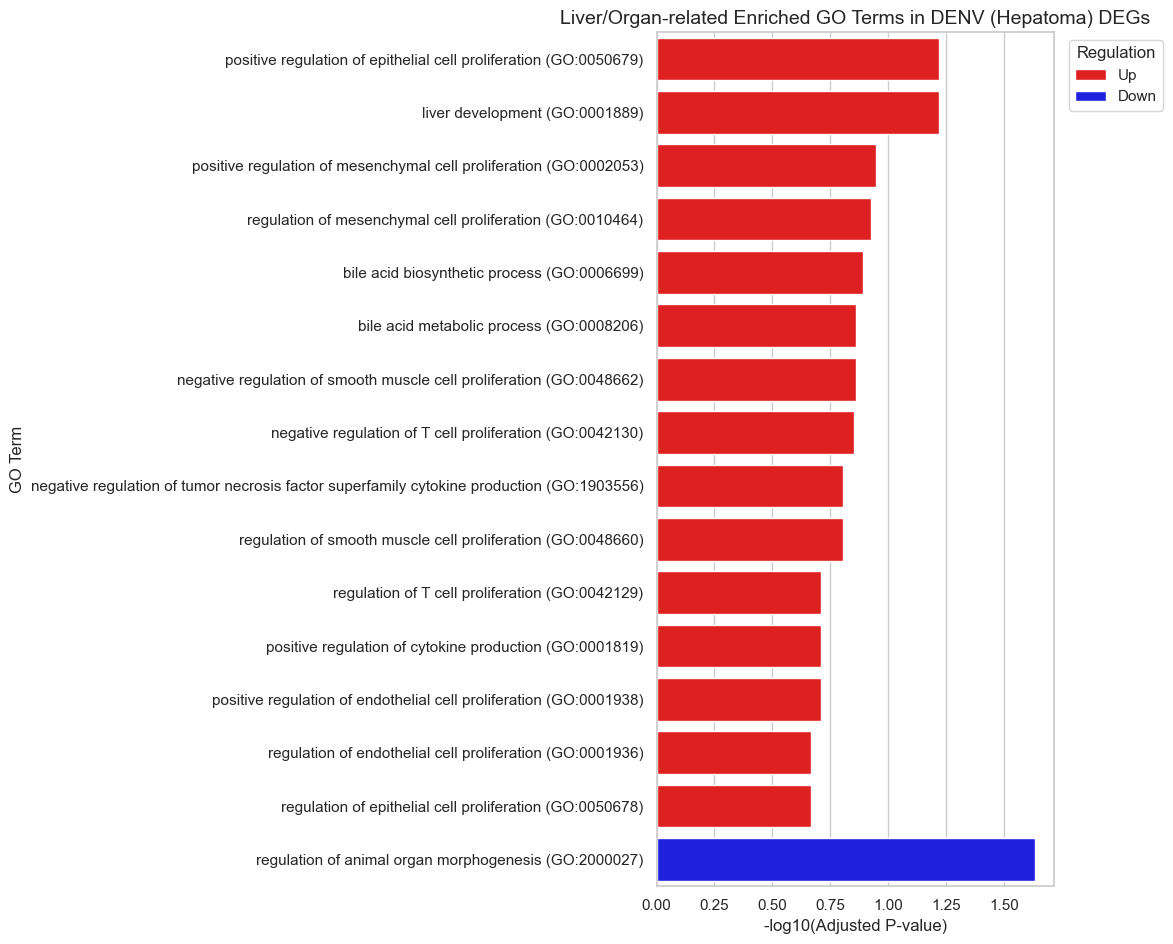

In [ ]:
# Load DENV (hepatoma) DEG data 
denv = pd.read_csv("C:/Users/ruman/Desktop/Project 2025/Final topic/1. My workflow/Analysis/Dengue Hepatoma cell_GSE110512.txt", sep="\t", skiprows=4)

# Filter DEGs
padj_thresh = 0.05
logfc_thresh = 1.0

denv_up = denv[(denv['adjusted p-val'] < padj_thresh) & (denv['log FC'] > logfc_thresh)]
denv_down = denv[(denv['adjusted p-val'] < padj_thresh) & (denv['log FC'] < -logfc_thresh)]

# Define liver-related keywords
keywords = [
    "liver", "hepatocyte", "hepatitis", "metabolism", "bile", "bilirubin",
    "organ development", "organ morphogenesis", "cell proliferation",
    "fibrosis", "cytokine"
]

def enrich_and_filter(gene_list, label):
    gene_list = [g for g in gene_list if isinstance(g, str) and g.isalpha()]
    if len(gene_list) < 5:
        print(f"Skipping {label} (less than 5 genes)")
        return pd.DataFrame(columns=['Term', '-log10(pval)', 'Group'])
    
    enr = enrichr(
        gene_list=gene_list,
        gene_sets='GO_Biological_Process_2021',
        organism='Human',
        outdir=None
    )
    df = enr.results.copy()
    df['-log10(pval)'] = -np.log10(df['Adjusted P-value'].replace(0, 1e-300))
    df['Group'] = label
    
    pattern = '|'.join(keywords)
    filtered = df[df['Term'].str.contains(pattern, case=False, na=False)].copy()
    return filtered.sort_values(by='Adjusted P-value').drop_duplicates(subset='Term').head(15)[['Term', '-log10(pval)', 'Group']]

# Enrichment Analysis 
up_terms = enrich_and_filter(denv_up['Gene Symbol'].dropna().tolist(), 'Up')
down_terms = enrich_and_filter(denv_down['Gene Symbol'].dropna().tolist(), 'Down')

# Combine & Plot 
plot_df = pd.concat([up_terms, down_terms], ignore_index=True)

plt.figure(figsize=(12, 0.6 * len(plot_df)))
sns.set_style("whitegrid")
sns.set_context("notebook")

sns.barplot(
    data=plot_df,
    y='Term',
    x='-log10(pval)',
    hue='Group',
    dodge=False,
    palette={'Up': 'red', 'Down': 'blue'}
)

plt.xlabel("-log10(Adjusted P-value)", fontsize=12)
plt.ylabel("GO Term", fontsize=12)
plt.title("Liver/Organ-related Enriched GO Terms in DENV (Hepatoma) DEGs", fontsize=14)
plt.legend(title="Regulation", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\ruman\AppData\Local\Temp\ipykernel_23148\3875780279.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


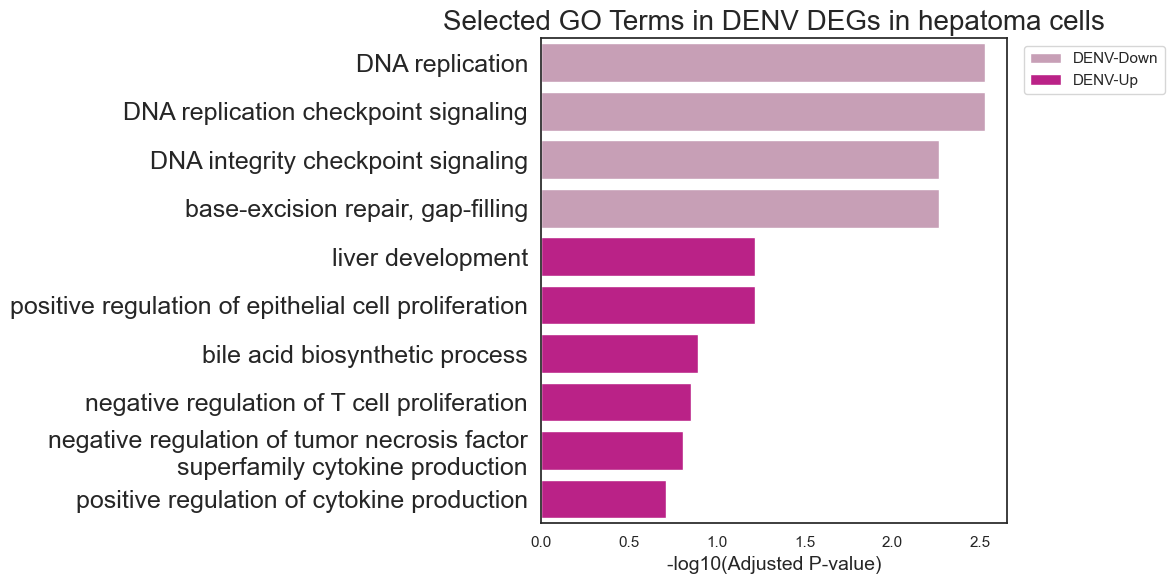

In [ ]:

# Load DENV (hepatoma) DEG data 
denv = pd.read_csv("C:/Users/ruman/Desktop/Project 2025/Final topic/1. My workflow/Analysis/Dengue Hepatoma cell_GSE110512.txt", sep="\t", skiprows=4)

# Filter DEGs 
padj_thresh = 0.05
logfc_thresh = 1.0
denv_up = denv[(denv['adjusted p-val'] < padj_thresh) & (denv['log FC'] > logfc_thresh)]
denv_down = denv[(denv['adjusted p-val'] < padj_thresh) & (denv['log FC'] < -logfc_thresh)]

# GO Terms of Interest (Upregulated) 
go_ids_up = ['GO:0050679', 'GO:0001889', 'GO:0042130', 'GO:1903556', 'GO:0001819', 'GO:0006699']

def enrich_and_filter_specific(gene_list, label, go_ids=None, top_n=4):
    gene_list = [g for g in gene_list if isinstance(g, str) and g.isalpha()]
    if len(gene_list) < 5:
        print(f"Skipping {label} (less than 5 genes)")
        return pd.DataFrame(columns=['Term', '-log10(pval)', 'Group'])

    enr = enrichr(
        gene_list=gene_list,
        gene_sets='GO_Biological_Process_2021',
        organism='Human',
        outdir=None
    )
    df = enr.results.copy()
    df['-log10(pval)'] = -np.log10(df['Adjusted P-value'].replace(0, 1e-300))
    df['Group'] = label

    if go_ids:
        pattern = '|'.join(go_ids)
        df = df[df['Term'].str.contains(pattern, case=False, na=False)]
        return df[['Term', '-log10(pval)', 'Group']]
    else:
        df = df.sort_values(by='Adjusted P-value').drop_duplicates(subset='Term')
        return df.head(top_n)[['Term', '-log10(pval)', 'Group']]

# Run enrichment
up_terms = enrich_and_filter_specific(denv_up['Gene Symbol'].dropna().tolist(), 'Up', go_ids=go_ids_up)
down_terms = enrich_and_filter_specific(denv_down['Gene Symbol'].dropna().tolist(), 'Down', top_n=4)


# Combine results
# Combine results and rename groups for legend
plot_df = pd.concat([up_terms, down_terms], ignore_index=True)
plot_df['Group'] = plot_df['Group'].replace({'Up': 'DENV-Up', 'Down': 'DENV-Down'})


# Remove GO IDs from terms
plot_df['Term'] = plot_df['Term'].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
plot_df['Term'] = plot_df['Term'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=55)))

# Sort bars by size 
plot_df = plot_df.sort_values(by='-log10(pval)', ascending=False)
# Plot 
plt.figure(figsize=(12, 0.6 * len(plot_df)))
sns.set_style("white")
sns.set_context("notebook")
ax = sns.barplot(
    data=plot_df,
    y='Term',
    x='-log10(pval)',
    hue='Group',
    dodge=False,
    palette={'DENV-Up': "#d30990", 'DENV-Down': "#ce98b7"}

)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.grid(False)
plt.xlabel("-log10(Adjusted P-value)", fontsize=16)
plt.ylabel("", fontsize=12)
plt.title("Selected GO Terms in DENV DEGs in hepatoma cells", fontsize=20)
plt.legend(title="", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Find hNPC_overlap in hepatoma cell line

In [ ]:
# Load DENV and ZIKV DEG files 
denv = pd.read_csv("Dengue Hepatoma cell_GSE110512.txt", sep="\t", skiprows=4)
zikv = pd.read_csv("Zika Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)

# Filter DEGs 
padj_thresh = 0.05
logfc_thresh = 1.0

denv_deg = denv[(denv['adjusted p-val'] < padj_thresh) & (abs(denv['log FC']) > logfc_thresh)]
zikv_deg = zikv[(zikv['adjusted p-val'] < padj_thresh) & (abs(zikv['log FC']) > logfc_thresh)]

# Find overlapping DEGs
overlap_genes = set(denv_deg['Gene Symbol']).intersection(set(zikv_deg['Gene Symbol']))

# Load Cytoscape node file 
node_df = pd.read_csv("DENV_nodes_with_shape_labels.csv")

# Mark hNPC_overlap 
node_df['hNPC_overlap'] = node_df['Node'].isin(overlap_genes)

#  Save updated file 
node_df.to_csv("DENV_nodes_with_hNPC_overlap.csv", index=False)

# Print overlap summary 
print(f"Genes in node file: {len(node_df)}")
print(f"Overlapping DEGs from Hepatoma and NPC: {len(overlap_genes)}")
print(f"Overlapping genes found in node file: {node_df['hNPC_overlap'].sum()}")


Genes in node file: 60
Overlapping DEGs from Hepatoma and NPC: 41
Overlapping genes found in node file: 8


In [ ]:
# Load input data files   
# Adjust the paths to match your file locations
denv_hepatoma = pd.read_csv("C:/Users/ruman/Desktop/Project 2025/Final topic/1. My workflow/Analysis/Dengue Hepatoma cell_GSE110512.txt", sep="\t", skiprows=4)
zikv_hnpc = pd.read_csv("C:/Users/ruman/Desktop/Project 2025/Final topic/1. My workflow/Analysis/Zika Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)
denv_hnpc = pd.read_csv("C:/Users/ruman/Desktop/Project 2025/Final topic/1. My workflow/Analysis/Dengue Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)

# Set DEG thresholds   
padj_thresh = 0.05
logfc_thresh = 1.0

# DEG filtering function   
def get_deg_sets(df):
    df = df.dropna(subset=['adjusted p-val', 'log FC', 'Gene Symbol'])
    up = set(df[(df['adjusted p-val'] < padj_thresh) & (df['log FC'] > logfc_thresh)]['Gene Symbol'])
    down = set(df[(df['adjusted p-val'] < padj_thresh) & (df['log FC'] < -logfc_thresh)]['Gene Symbol'])
    degs = up.union(down)
    return up, down, degs

# Get DEG sets   
denv_hep_up, denv_hep_down, denv_hep_all = get_deg_sets(denv_hepatoma)
zikv_up, zikv_down, zikv_all = get_deg_sets(zikv_hnpc)
denv_nsc_up, denv_nsc_down, denv_nsc_all = get_deg_sets(denv_hnpc)

# Overlaps   
overlap_denv_zikv = denv_hep_all.intersection(zikv_all)
overlap_denv_nsc = denv_hep_all.intersection(denv_nsc_all)

# Print Summary   
print("   DENV (hepatoma) DEG Summary   ")
print(f"Total DEGs: {len(denv_hep_all)}")
print(f"Upregulated: {len(denv_hep_up)}")
print(f"Downregulated: {len(denv_hep_down)}\n")

print("   DEG Overlaps   ")
print(f"DENV (hepatoma) ∩ ZIKV (hNPC): {len(overlap_denv_zikv)} genes")
print(f"DENV (hepatoma) ∩ DENV (hNPC): {len(overlap_denv_nsc)} genes")

# Optional: Save overlap gene lists
pd.Series(sorted(overlap_denv_zikv)).to_csv("DENV_hep_AND_ZIKV_hNPC_overlap_genes.txt", index=False, header=False)
pd.Series(sorted(overlap_denv_nsc)).to_csv("DENV_hep_AND_DENV_hNPC_overlap_genes.txt", index=False, header=False)


=== DENV (hepatoma) DEG Summary ===
Total DEGs: 335
Upregulated: 269
Downregulated: 66

=== DEG Overlaps ===
DENV (hepatoma) ∩ ZIKV (hNPC): 40 genes
DENV (hepatoma) ∩ DENV (hNPC): 173 genes


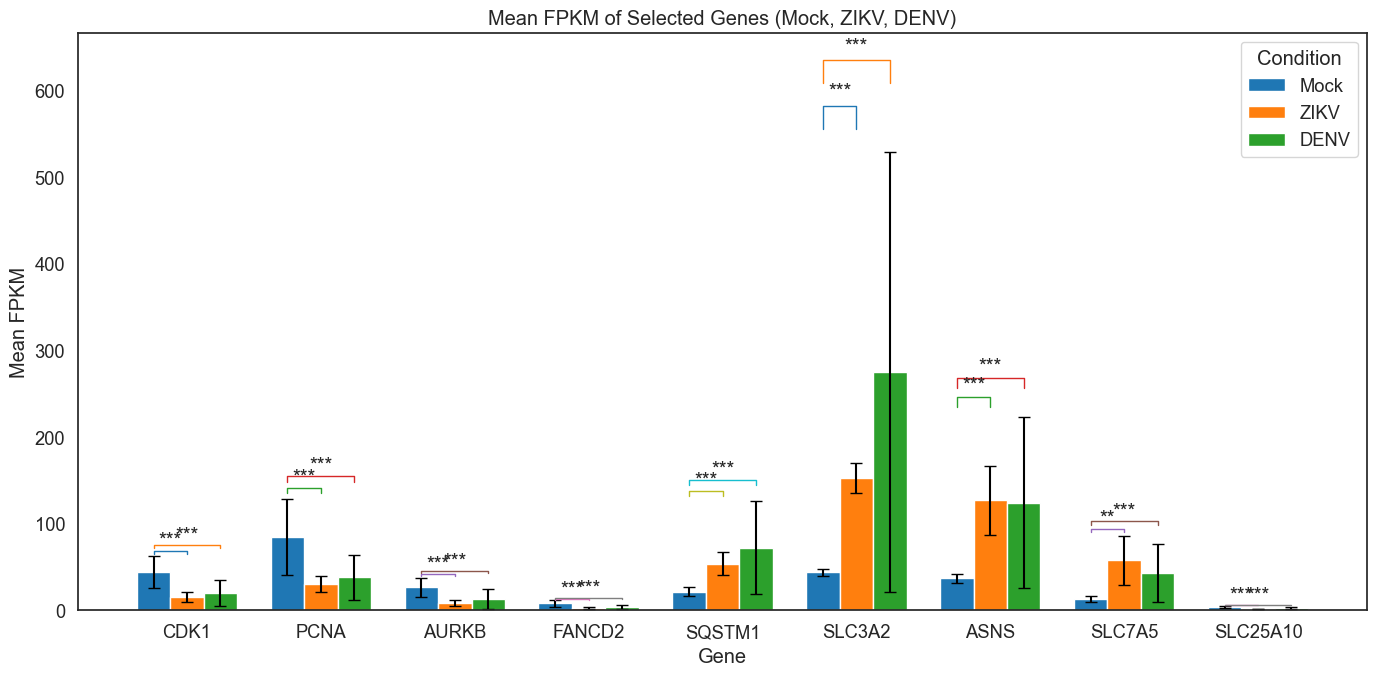

In [ ]:

# Load the summary table (9 genes, means/SDs/p-values)
df = pd.read_csv('genes_fpkm_summary_with_pvals.csv')

# Convert p-values to floats
p_zikv = df['P (Mock vs ZIKV)'].astype(float)
p_denv = df['P (Mock vs DENV)'].astype(float)

# Define the genes and extract the mean/SD columns
genes     = df['Gene'].tolist()
mock_mean = df['Mock Mean'].to_numpy()
mock_sd   = df['Mock SD'].to_numpy()
zikv_mean = df['ZIKV Mean'].to_numpy()
zikv_sd   = df['ZIKV SD'].to_numpy()
denv_mean = df['DENV Mean'].to_numpy()
denv_sd   = df['DENV SD'].to_numpy()

# Bar positions: 3 bars per gene
n = len(genes)
bar_width = 0.25
x = np.arange(n)
pos_mock = x - bar_width
pos_zikv = x
pos_denv = x + bar_width

# Create the figure
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Plot bars with default colours 
ax.bar(pos_mock, mock_mean, width=bar_width, yerr=mock_sd, capsize=4, label='Mock')
ax.bar(pos_zikv, zikv_mean, width=bar_width, yerr=zikv_sd, capsize=4, label='ZIKV')
ax.bar(pos_denv, denv_mean, width=bar_width, yerr=denv_sd, capsize=4, label='DENV')

# Function to determine asterisks for p-value thresholds
def significance_stars(p):
    if p < 0.005:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Add brackets and stars per gene
for i, gene in enumerate(genes):
    # Height above which to draw the brackets
    bar_heights = [
        mock_mean[i] + mock_sd[i],
        zikv_mean[i] + zikv_sd[i],
        denv_mean[i] + denv_sd[i]
    ]
    max_height = max(bar_heights)
    # Small offset as a fraction of the bar height
    offset = max_height * 0.05 if max_height > 0 else 0.1

    # Add bracket for Mock vs ZIKV if significant
    star = significance_stars(p_zikv[i])
    if star:
        # Bracket between Mock and ZIKV bars
        h = max_height + offset
        ax.plot(
            [pos_mock[i], pos_mock[i], pos_zikv[i], pos_zikv[i]],
            [h, h + offset, h + offset, h],
            lw=1.0
        )
        ax.text(
            (pos_mock[i] + pos_zikv[i]) / 2,
            h + 1.2 * offset,
            star,
            ha='center',
            va='bottom'
        )

    # Add bracket for Mock vs DENV if significant
    star = significance_stars(p_denv[i])
    if star:
        # Draw this bracket slightly higher if the previous one exists
        extra_offset = (3 * offset) if significance_stars(p_zikv[i]) else offset
        h2 = max_height + extra_offset
        ax.plot(
            [pos_mock[i], pos_mock[i], pos_denv[i], pos_denv[i]],
            [h2, h2 + offset, h2 + offset, h2],
            lw=1.0
        )
        ax.text(
            (pos_mock[i] + pos_denv[i]) / 2,
            h2 + 1.2 * offset,
            star,
            ha='center',
            va='bottom'
        )

# Label axes and legend
ax.set_xticks(x)
ax.set_xticklabels(genes)
ax.set_xlabel('Gene')
ax.set_ylabel('Mean FPKM')
ax.set_title('Mean FPKM of Selected Genes (Mock, ZIKV, DENV)')
ax.legend(title='Condition')

# Show a simple black frame and remove the default grid
for spine in ax.spines.values():
    spine.set_visible(True)
    
ax.grid(False)

plt.tight_layout()
plt.show()


In [2]:
# Save to PDF
!jupyter nbconvert "DENV_Hepatoma Analysis.ipynb" --to webpdf \
  --WebPDFExporter.allow_chromium_download=True \
  --output "DENV_Hepatoma Analysis"

[NbConvertApp] Converting notebook DENV_Hepatoma Analysis.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 329909 bytes to DENV_Hepatoma Analysis.pdf
